**Описание датасета.**


Данные о продажах в магазинах на основе данных Corporación Favorita, крупного розничного продавца продуктов питания из Эквадора.

https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

train.csv

* **store_nbr** - определяет магазин, в котором продаются товары.
* **family** - определяет тип продаваемого продукта.
* **sales** - показывают общий объем продаж для семейства продуктов в конкретном магазине на заданную дату. 
              Дробные значения возможны, так как продукты могут продаваться в дробных единицах (например, 1,5 кг сыра вместо 1 пакета чипсов).
* **onpromotion** - общее количество товаров в семействе продуктов, которые рекламировались в магазине на определенную дату.

test.csv
* Тестовые данные, имеют те же характеристики, что и обучающие данные.
* Даты в тестовых данных указаны в течении 15 дней после последней даты в обучающих данных.

Дополнительные датасеты, данные которых также важны как признаки:

* stores.csv - данные по магазинам включая город, штат, тип и группу похожих магазинов(cluster).
* holidays_events.csv - праздники и события.
* oil.csv - ежедневная цена на нефть.

Эквадор - страна, зависящая от нефти, и её экономическое состояние очень уязвимо к колебаниям цен на нефть.

**1.1. Подключение библиотек и скриптов.**

In [59]:
# 1. Основные библиотеки.
import numpy as np
import pandas as pd

# 2. Разделение датасета.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# 3. Модели.
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

# 4. Метрики качества.
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score

# 5. Для визуализации.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 6. Дополнительные библиотеки.
from datetime import datetime
import math
from timeit import default_timer as timer

In [60]:
# Игнорировать предупреждения.
import warnings
warnings.filterwarnings('ignore')

In [61]:
# Магическая команда для отображения графиков прямо в Jupyter Notebook, а не в отдельном окне.
%matplotlib inline
# Магическая функция для более четкого отображения графиков.
%config InlineBackend.figure_format = 'svg'
# Используем для графиков стиль “fivethirtyeight”. 
plt.style.use('fivethirtyeight')
# Задаем глобальный размер шрифта для графиков.
matplotlib.rcParams.update({'font.size': 14})

In [62]:
# Применим следующую настройку, чтобы можно было просматривать все строки столбцы датафрейма:
pd.options.display.max_rows = 1690785
pd.options.display.max_columns = 100

In [63]:
# Функция отрисовки графика.
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [64]:
# Пути к директориям и файлам.
TRAIN_DATASET_PATH = 'Data/train.csv.zip'
TEST_DATASET_PATH = 'Data/test.csv'
STORES_DATASET_PATH = 'Data/stores.csv'
EVENTS_DATASET_PATH = 'Data/holidays_events.csv'
OIL_DATASET_PATH = 'Data/oil.csv'

**1.2. Загрузка данных.**

In [65]:
# Используем функцию reduce_mem_usage для оптимизации оперативной памяти занимаемой датасетом.
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [66]:
# Загрузим тренировочный дата фрейм.
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 137.37 MB
Memory usage after optimization is: 40.14 MB
Decreased by 70.8%


In [67]:
# Загрузим тестовый дата фрейм.
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 1.09 MB
Memory usage after optimization is: 0.25 MB
Decreased by 77.3%


In [68]:
# Загрузим stores дата фрейм.
df_stores = pd.read_csv(STORES_DATASET_PATH)
df_stores = reduce_mem_usage(df_stores)

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 11.5%


In [69]:
# Загрузим holidays_events дата фрейм.
df_events = pd.read_csv(EVENTS_DATASET_PATH)
df_events = reduce_mem_usage(df_events)

Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.02 MB
Decreased by -41.7%


In [70]:
# Загрузим oil дата фрейм.
df_oil = pd.read_csv(OIL_DATASET_PATH)
df_oil = reduce_mem_usage(df_oil)

Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.05 MB
Decreased by -156.1%


**1.3. Exploratory Data Analysis (EDA).**

In [71]:
# Выведем на экран тренировочный дата фрейм.
df_train.tail(10)

,id,date,store_nbr,family,sales,onpromotion
3000878,3000878,2017-08-15,9,MAGAZINES,11.000000,0
3000879,3000879,2017-08-15,9,MEATS,449.227997,0
3000880,3000880,2017-08-15,9,PERSONAL CARE,522.000000,11
3000881,3000881,2017-08-15,9,PET SUPPLIES,6.000000,0
3000882,3000882,2017-08-15,9,PLAYERS AND ELECTRONICS,6.000000,0
3000883,3000883,2017-08-15,9,POULTRY,438.132996,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.552994,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729004,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000000,0


In [72]:
# Просмотрим общую информацию о тренировочном дата фрейме.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype   
---  ------       -----   
 0   id           int32   
 1   date         category
 2   store_nbr    int8    
 3   family       category
 4   sales        float32 
 5   onpromotion  int16   
dtypes: category(2), float32(1), int16(1), int32(1), int8(1)
memory usage: 40.1 MB


In [73]:
# Выведем на экран тестовый дата фрейм.
df_test.head(10)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
5,3000893,2017-08-16,1,BREAD/BAKERY,12
6,3000894,2017-08-16,1,CELEBRATION,0
7,3000895,2017-08-16,1,CLEANING,25
8,3000896,2017-08-16,1,DAIRY,45
9,3000897,2017-08-16,1,DELI,18


In [74]:
# Просмотрим общую информацию о тренировочном дата фрейме.
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           28512 non-null  int32   
 1   date         28512 non-null  category
 2   store_nbr    28512 non-null  int8    
 3   family       28512 non-null  category
 4   onpromotion  28512 non-null  int16   
dtypes: category(2), int16(1), int32(1), int8(1)
memory usage: 252.7 KB


In [75]:
# Просмотрим сколько строк и столбцов в датафреймах.
print(f'Строк в тренировочном наборе: {df_train.shape[0]}')
print(f'Столбцов в тренировочном наборе: {df_train.shape[1]}', '\n')
print(f'Строк в тестовом наборе: {df_test.shape[0]}')
print(f'Столбцов в тестовом наборе: {df_test.shape[1]}')

Строк в тренировочном наборе: 3000888
Столбцов в тренировочном наборе: 6 

Строк в тестовом наборе: 28512
Столбцов в тестовом наборе: 5


In [76]:
# Проверим нет ли пропусков в дата фреймах.
print(f'Пропусков в тренировочном наборе: {df_train.isnull().sum().sum()}')
print(f'Пропусков в тестовом наборе: {df_test.isnull().sum().sum()}')
# df_train.isnull().sum()
# df_test.isnull().sum()

Пропусков в тренировочном наборе: 0
Пропусков в тестовом наборе: 0


In [77]:
# Проверим нет ли значений NaN в дата фреймах.
print(f'Значений NaN в тренировочном наборе: {df_train.isna().sum().sum()}')
print(f'Значений NaN в тестовом наборе: {df_test.isna().sum().sum()}')
# df_train.isna().sum()
# df_test.isna().sum()

Значений NaN в тренировочном наборе: 0
Значений NaN в тестовом наборе: 0


In [78]:
# Просмотрим категории продаваемых товаров:
families=df_train.family.unique()
list(families)

['AUTOMOTIVE',
 'BABY CARE',
 'BEAUTY',
 'BEVERAGES',
 'BOOKS',
 'BREAD/BAKERY',
 'CELEBRATION',
 'CLEANING',
 'DAIRY',
 'DELI',
 'EGGS',
 'FROZEN FOODS',
 'GROCERY I',
 'GROCERY II',
 'HARDWARE',
 'HOME AND KITCHEN I',
 'HOME AND KITCHEN II',
 'HOME APPLIANCES',
 'HOME CARE',
 'LADIESWEAR',
 'LAWN AND GARDEN',
 'LINGERIE',
 'LIQUOR,WINE,BEER',
 'MAGAZINES',
 'MEATS',
 'PERSONAL CARE',
 'PET SUPPLIES',
 'PLAYERS AND ELECTRONICS',
 'POULTRY',
 'PREPARED FOODS',
 'PRODUCE',
 'SCHOOL AND OFFICE SUPPLIES',
 'SEAFOOD']

In [79]:
# Выведем сколько всего категорий товаров.
print(f'Всего категорий товаров: {len(families)}')

Всего категорий товаров: 33


In [80]:
# Выведем сколько всего магазинов.
stores=df_train.store_nbr.unique()
print(f'Всего магазинов: {len(stores)}')

Всего магазинов: 54


In [81]:
# Просмотрим статистические данные.
df_train.describe().round(2)

,id,store_nbr,sales,onpromotion
count,3000888.00,3000888.00,3000888.00,3000888.00
mean,1500443.50,27.50,357.78,2.60
std,866281.89,15.59,1102.00,12.22
min,0.00,1.00,0.00,0.00
25%,750221.75,14.00,0.00,0.00
50%,1500443.50,27.50,11.00,0.00
75%,2250665.25,41.00,195.85,0.00
max,3000887.00,54.00,124717.00,741.00


Вызывает интерес max значения sales, остальные показатели в разрезе признаков в норме.
Давайте посмотрим sales поближе.

In [82]:
df_train[df_train['sales'] >= 50000]

,id,date,store_nbr,family,sales,onpromotion
2139699,2139699,2016-04-18,45,GROCERY I,76090.000000,38
2144154,2144154,2016-04-21,20,GROCERY I,87438.515625,53
2145045,2145045,2016-04-21,45,GROCERY I,53874.000000,44
2153031,2153031,2016-04-26,2,GROCERY I,63434.000000,30
2163723,2163723,2016-05-02,2,GROCERY I,124717.000000,59
2445984,2445984,2016-10-07,39,MEATS,89576.359375,0


Как видим наибольшие покупки совершались с середины апреля до начала мая в продуктовых товарах. 

Посмотрим глубже на произошедшие события в дата фрейме в holidays_events.

In [83]:
# Выведем на экран дата фрейм.
df_events.head(10)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,0.0
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,0.0
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,0.0
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,0.0
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,0.0
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,0.0
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,0.0
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,0.0
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,0.0
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,0.0


In [84]:
# Посмотрим общую информацию о дата фрейме.
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   date         350 non-null    category
 1   type         350 non-null    category
 2   locale       350 non-null    category
 3   locale_name  350 non-null    category
 4   description  350 non-null    category
 5   transferred  350 non-null    float32 
dtypes: category(5), float32(1)
memory usage: 20.0 KB


In [85]:
# Просмотрим типы событий:
type_a=df_events.type.unique()

list(type_a)

['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event']

In [86]:
# Проиндексируем колонку 'date' для использования сортировки.
df_events = df_events
df_events = df_events.set_index(['date'])
#df_events

In [87]:
# Выведем на экран события с середины апреля до начала мая.
df_events['2016-04-12':'2016-05-02']

,type,locale,locale_name,description,transferred
date,,,,,
2016-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,0.0
2016-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,0.0
2016-04-16,Event,National,Ecuador,Terremoto Manabi,0.0
2016-04-17,Event,National,Ecuador,Terremoto Manabi+1,0.0
2016-04-18,Event,National,Ecuador,Terremoto Manabi+2,0.0
2016-04-19,Event,National,Ecuador,Terremoto Manabi+3,0.0
2016-04-20,Event,National,Ecuador,Terremoto Manabi+4,0.0
2016-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,0.0
2016-04-21,Event,National,Ecuador,Terremoto Manabi+5,0.0


Землетрясение магнитудой 7,8 произошло в Эквадоре 16 апреля 2016 года. Люди объединились в усилиях по оказанию помощи, жертвуя воду и другие продукты первой необходимости, что сильно повлияло на продажи в супермаркетах в течение нескольких недель после землетрясения.
https://www.youtube.com/watch?v=BchJzgUgWq4&t=686s

Вывод:
мы не можем пренебречь этим фактором для данного региона, поэтому оставляем данные по продажам в тренировочном дата сете как есть.

In [88]:
# Просмотрим информацию в других дата фреймах.
df_stores.head(10)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [89]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   store_nbr  54 non-null     int8    
 1   city       54 non-null     category
 2   state      54 non-null     category
 3   type       54 non-null     category
 4   cluster    54 non-null     int8    
dtypes: category(3), int8(2)
memory usage: 2.0 KB


In [90]:
df_oil.head(10)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997
5,2013-01-08,93.209999
6,2013-01-09,93.080002
7,2013-01-10,93.809998
8,2013-01-11,93.599998
9,2013-01-14,94.269997


In [91]:
# Просмотрим сколько значений NaN в датафрейме df_oil.
df_oil.isna().sum().sum()

43

In [92]:
df_oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [93]:
# Для заполнения значений NaN цены на нефть применим метод ffill - заполнение NaN по последней известной цене,
# сперва удалив NaN значения.
df_oil.loc[0, 'dcoilwtico'] = df_oil.loc[1, 'dcoilwtico']
prev_row_value = None
for idx, row in df_oil.iterrows():
    if math.isnan(row['dcoilwtico']):
        df_oil.loc[idx, 'dcoilwtico'] = prev_row_value
    else:
        prev_row_value = row['dcoilwtico']


df_oil.rename(columns = {'dcoilwtico':'oil_price'}, inplace = True)
df_oil['oil_price'] = df_oil['oil_price'].fillna(method="ffill")

In [94]:
# Перепроверим еще раз значения Nan.
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   date       1218 non-null   category
 1   oil_price  1218 non-null   float32 
dtypes: category(1), float32(1)
memory usage: 49.1 KB


In [95]:
# Посмотрим на средний объем продажи в разрезе дат.
average_sales = df_train.groupby('date').mean()['sales']
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
Name: sales, dtype: float32

In [96]:
# Вычислим скользящую среднюю average_sales для построения на графике тренда продаж.
trend = average_sales.rolling(window=365, center=True, min_periods=183).mean()

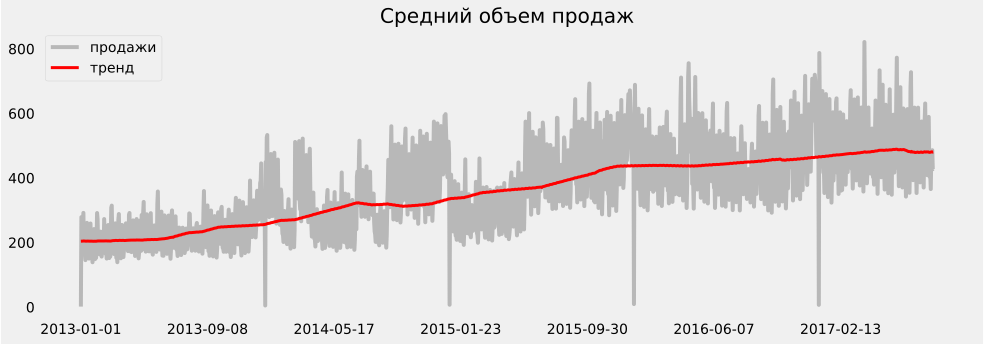

In [97]:
# Выведем на график тренд и среднюю объема продаж.
fig, ax = plt.subplots(figsize=(15,5))
average_sales.plot(alpha=0.5, label='продажи', title="Средний объем продаж", color='gray', ax=ax)
trend.plot(linewidth=3, label='тренд', color='red', ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(False)
ax.legend()
ax.set_xlabel('')

plt.savefig('average_sales.png', dpi=300)

**1.4. Preprocessing (подготовка исходных данных).**

In [98]:
# Выберем(определим) итоговые ПрИзНаКи.
final_features=['store_nbr', 'family', 'onpromotion', 'year', 'month', 'day_of_week', 'day_of_month', 'holiday', 'oil_price', 'city', 'state', 'type', 'cluster']

In [99]:
# Развернем колонку 'date' в тренировочном и тестовом датасете в отдельные колонки год - месяц -день.
df_train['year'] = df_train['date'].apply(lambda x: int(x.split('-')[0]))
df_train['month'] = df_train['date'].apply(lambda x: int(x.split('-')[1]))
df_train['day_of_week'] = df_train['date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d').weekday())
df_train['day_of_month'] = df_train['date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d').day)

df_test['year'] = df_test['date'].apply(lambda x: int(x.split('-')[0]))
df_test['month'] = df_test['date'].apply(lambda x: int(x.split('-')[1]))
df_test['day_of_week'] = df_test['date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d').weekday())
df_test['day_of_month'] = df_test['date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d').day)

df_train[['year', 'month', 'day_of_week', 'day_of_month', 'sales']].head(10)

,year,month,day_of_week,day_of_month,sales
0,2013,1,1,1,0.0
1,2013,1,1,1,0.0
2,2013,1,1,1,0.0
3,2013,1,1,1,0.0
4,2013,1,1,1,0.0
5,2013,1,1,1,0.0
6,2013,1,1,1,0.0
7,2013,1,1,1,0.0
8,2013,1,1,1,0.0
9,2013,1,1,1,0.0


In [100]:
# Объединим df_train и df_test с колонкой holiday df_events.
df_events = df_events.reset_index(['date'])

df_train['holiday'] = [0] * df_train.shape[0]
df_test['holiday'] = [0] * df_test.shape[0]

holiday_type = { "National": 1, "Regional": 2, "Local": 3}


for idx, row in df_events.iterrows():
    if row['type'] in ['Event', 'Transfer', 'Bridge', 'Additional'] or (row['type'] == 'Holiday' and row['transferred'] == False):
        df_train.loc[df_train['date'] == row['date'], 'holiday'] = holiday_type[row['locale']]
        df_test.loc[df_test['date'] == row['date'], 'holiday'] = holiday_type[row['locale']]
    else:
        df_train.loc[df_train['date'] == row['date'], 'holiday'] = 0 # нет праздника
        df_test.loc[df_test['date'] == row['date'], 'holiday'] = 0 # нет праздника
        
df_train[['date','holiday', 'sales']].head(10)

,date,holiday,sales
0,2013-01-01,1,0.0
1,2013-01-01,1,0.0
2,2013-01-01,1,0.0
3,2013-01-01,1,0.0
4,2013-01-01,1,0.0
5,2013-01-01,1,0.0
6,2013-01-01,1,0.0
7,2013-01-01,1,0.0
8,2013-01-01,1,0.0
9,2013-01-01,1,0.0


In [101]:
# Объединим df_train и df_test с колонкой oil price df_oil.     
df_train = pd.merge(df_train, df_oil, how='left', left_on=['date'], right_on = ['date'])
df_test = pd.merge(df_test, df_oil, how='left', left_on=['date'], right_on = ['date'])

df_train[['date', 'oil_price', 'sales']].head(10)

,date,oil_price,sales
0,2013-01-01,93.139999,0.0
1,2013-01-01,93.139999,0.0
2,2013-01-01,93.139999,0.0
3,2013-01-01,93.139999,0.0
4,2013-01-01,93.139999,0.0
5,2013-01-01,93.139999,0.0
6,2013-01-01,93.139999,0.0
7,2013-01-01,93.139999,0.0
8,2013-01-01,93.139999,0.0
9,2013-01-01,93.139999,0.0


In [102]:
# Объединим df_train и df_test с колонками df_stores.
df_train = pd.merge(df_train, df_stores, how='left', left_on=['store_nbr'], right_on = ['store_nbr'])
df_test = pd.merge(df_test, df_stores, how='left', left_on=['store_nbr'], right_on = ['store_nbr'])

df_train[['store_nbr', 'city', 'state', 'type', 'cluster']].head(10)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,1,Quito,Pichincha,D,13
2,1,Quito,Pichincha,D,13
3,1,Quito,Pichincha,D,13
4,1,Quito,Pichincha,D,13
5,1,Quito,Pichincha,D,13
6,1,Quito,Pichincha,D,13
7,1,Quito,Pichincha,D,13
8,1,Quito,Pichincha,D,13
9,1,Quito,Pichincha,D,13


In [103]:
# Просмотрим объединенный дата фрейм.
df_train.head(10)

,id,date,store_nbr,family,sales,onpromotion,year,month,day_of_week,day_of_month,holiday,oil_price,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,1,93.139999,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,1,93.139999,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,1,93.139999,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,1,93.139999,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,1,93.139999,Quito,Pichincha,D,13
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0,2013,1,1,1,1,93.139999,Quito,Pichincha,D,13
6,6,2013-01-01,1,CELEBRATION,0.0,0,2013,1,1,1,1,93.139999,Quito,Pichincha,D,13
7,7,2013-01-01,1,CLEANING,0.0,0,2013,1,1,1,1,93.139999,Quito,Pichincha,D,13
8,8,2013-01-01,1,DAIRY,0.0,0,2013,1,1,1,1,93.139999,Quito,Pichincha,D,13
9,9,2013-01-01,1,DELI,0.0,0,2013,1,1,1,1,93.139999,Quito,Pichincha,D,13


Далее поработаем с признаками, потому что из коробки не работают при обучении модели в Sclearn.
Отдельно придется поработать с 'oil_price' и 'onpromotion'.

In [104]:
# Закодируем категориальные признаки как целочисленный массив (преобразуем к виду целых чисел от 0 до n_categories - 1).
# Новым значениям в тестовых данных (модель не увидела их в тренировочных) присвоим значения NaN.
cat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

df_train[final_features] = cat_encoder.fit_transform(df_train[final_features])
df_test[final_features] = cat_encoder.transform(df_test[final_features])

In [105]:
# Используем метод "вменения", для значений NaN подставим среднее значение. 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(df_train['oil_price'].array.reshape(-1, 1))   # преобразуем в двумерный массив для numpy (требование SimpleImputer)
imputer.fit(df_test['oil_price'].array.reshape(-1, 1))   
df_train['oil_price'] = imputer.transform(df_train[['oil_price']])
df_test['oil_price'] = imputer.transform(df_test[['oil_price']])

imputer.fit(df_train['onpromotion'].array.reshape(-1, 1))   
imputer.fit(df_test['onpromotion'].array.reshape(-1, 1))   
df_train['onpromotion'] = imputer.transform(df_train[['onpromotion']])
df_test['onpromotion'] = imputer.transform(df_test[['onpromotion']])

In [106]:
# Приведем нормализацию признаков (масштабирование), а также выделим ЦеЛеВоЕ значения цены.
X = df_train[final_features]
X_test = df_test[final_features]
y = df_train['sales']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

print('Пример строки после масштабирования')
print(np.round(X_scaled[0], 4).tolist())

Пример строки после масштабирования
[0.0, 0.0, 0.0, 0.0, 0.0, 0.1667, 0.0, 0.3333, 0.6687, 0.8571, 0.8, 0.75, 0.75]


In [107]:
# Разобьем тренировочный датафрейм на тренировочный (x_train, y_train) и валидационный (x_val, y_val) с помощью функции train_test_split.
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print('Размер тренировочного датафрейма:', X_train.shape)
print('Размер валидационного датафрейма:', X_val.shape)

Размер тренировочного датафрейма: (2100621, 13)
Размер валидационного датафрейма: (900267, 13)


**1.5. Построение модели**

In [108]:
# Для автоматического подбора наилучших параметров (гиперпараметров) для нашей модели зададим такие параметры:
parameters = [{
    'n_estimators': [10, 75], 
    'max_features': np.arange(3, 10), 
    'max_depth': np.arange(4, 13),
}] 

In [109]:
# Создадим модель GridSearchCV со следующими аргументами:
"""ВНИМАНИЕ - активация подбора гиперпараметров требует не менее 20 Gb свободного места на диске C и затратно по времени"""
#grid = GridSearchCV(estimator = RandomForestRegressor(random_state=42), param_grid = parameters, scoring = 'roc_auc', n_jobs=-1)

'ВНИМАНИЕ - активация подбора гиперпараметров требует не менее 20 Gb свободного места на диске C и затратно по времени'

In [110]:
# Обучим модель на тренировочном наборе данных.
#start_time = timer()
#grid.fit(X_train, y_train)
#print(f'Модель обучена за: {timer() - start_time:.2f} сек')

In [111]:
# Просмотрим параметры лучшей модели с помощью атрибута best_params_.
#grid.best_params_

In [112]:
# Обучим итоговую модель RandomForestClassifier на лучших параметрах. 
model = RandomForestRegressor(max_depth=10, max_features=8, n_estimators=55, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

print(f'Train R2: {model.score(X_train, y_train):.3f}\t')
print(f'Test R2: {model.score(X_val, y_val):.3f}')

Train R2: 0.865	
Test R2: 0.861


In [113]:
# Cделаем предсказание.
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_val)

"""ВНИМАНИЕ - отрисовка графика потребялет много ресурсов компьютера, не уверен не включай"""
# evaluate_preds(y_train, y_train_pred, y_val, y_test_pred)


'ВНИМАНИЕ - отрисовка графика потребялет много ресурсов компьютера, не уверен не включай'

**Формирование файла с прогнозом**

In [114]:
predictions = model.predict(X_test_scaled)
predictions

array([   9.4785953 ,    5.81582358,   31.26688766, ..., 1013.4987796 ,
        696.39145282,   17.61196839])

In [115]:
output = pd.DataFrame({"id": df_test.index+df_train.shape[0], "sales": predictions})
output.head(10)

,id,sales
0,3000888,9.478595
1,3000889,5.815824
2,3000890,31.266888
3,3000891,2447.267908
4,3000892,31.981013
5,3000893,701.996887
6,3000894,77.427068
7,3000895,930.624126
8,3000896,1057.023205
9,3000897,461.947309


In [116]:
output.to_csv('./predictions_.csv', index=False)